In [12]:
import matplotlib.pyplot as plt
import numpy as np
import vegas
import random as rand

pb_convert = 3.894E8 # conversion factor GeV^-2 -> pb
MZ = 91.188    # Z boson mass
GAMMAZ = 2.4414 # Z boson width
alpha = 1/132.507 # alpha QED
Gfermi = 1.16639E-5 # fermi constant
sw2 = 0.222246 # sin^2(weinberg angle)

# e+e- COM energy in GeV
ECM = 90
hats = ECM ** 2

print('ECM', ECM, 'GeV')

RMAX = 1
D = 1 # no. of integral dimensions
bins = 1000

def fn(x):
    dx = 0.0
    for d in range(D):
        dx += x[d] # x[d] is integ. point in each dimension 
    I = pb_convert * ((np.pi * alpha ** 2) / (2 * hats)) * (1 + dx ** 2)
    dI = np.zeros(bins, dtype=float) # list of bins zero entries, note fn called nitn*neval*D (+1) times
    dr = 2 * RMAX / len(dI) # defines bins in r (or x)
    j = int((dx + RMAX) / dr) # defines positive labels for the bins
    dI[j] = I
    return dict(I=I, dI=dI)

integ_hist = vegas.Integrator(D * [(-1, 1)])

# results returned in a dictionary
nevals = 10 ** 5
nitns = 2
sigma_hist = integ_hist(fn, nitn = nitns, neval = nevals)
print(sigma_hist.summary())
#print('dI/I =', sigma_hist['dI'] / sigma_hist['I']) #normalised cross-section
print('Sum(dI/I) =', sum(sigma_hist['dI']) / sigma_hist['I']) #should be 1

# calculate cross sections and error
computed = sigma_hist['I'].mean
analytic = (4 * np.pi * alpha ** 2) / (3 * hats)
error = sigma_hist['I'].sdev

# don't forget to convert the GeV^-2 to pb! 
print('Vegas Cross-Section = '+str(computed)+' +/ '+str(error)+' pb')
print('Analytical Cross-Section = '+str(analytic * pb_convert)+' pb')

ECM 90 GeV
itn   integral        wgt average         chi2/dof        Q
-----------------------------------------------------------
  1   11.4689035(15)  11.4689030(15)          0.00     1.00
  2   11.4689049(14)  11.4689752(10)  249228288.67     0.00

Sum(dI/I) = 0.9997886307152(40)
Vegas Cross-Section = 11.468975210574513 +/ 9.983358966998271e-07 pb
Analytical Cross-Section = 11.468903393827555 pb


In [2]:
for x in integ_hist.random_batch():
    print('hi')

hi


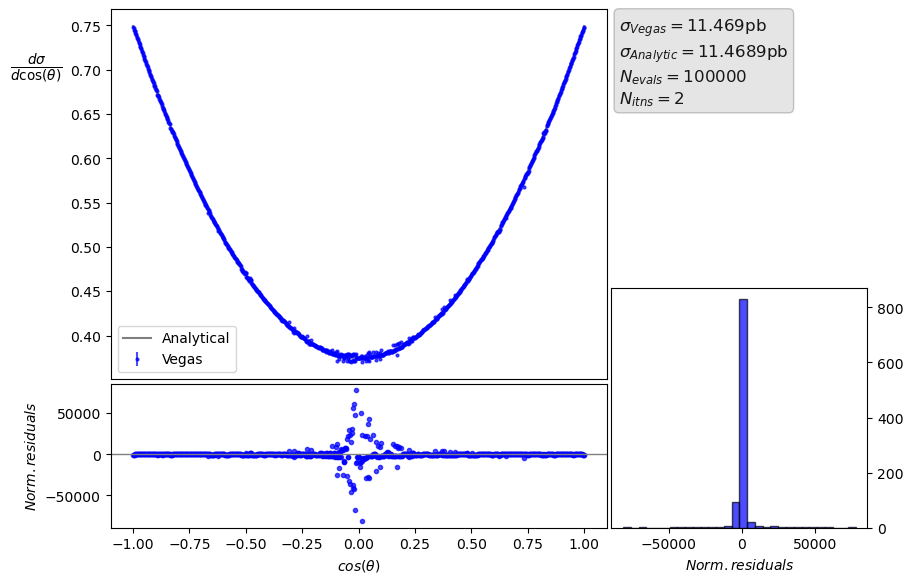

In [13]:
def func(n, x):
    return n * (1 / analytic) * (1 + x ** 2)

dIs = []
dI_errs = []
for i in sigma_hist['dI']:
    dIs += [i.mean / sigma_hist['I'].mean]
    dI_errs += [(i / sigma_hist['I']).sdev]

xs = np.linspace(-RMAX + (RMAX / bins), RMAX - (RMAX / bins), bins)

fig, ax = plt.subplots()

y = func((np.pi * alpha ** 2) / (2 * hats), xs) 

ax.plot(xs, y, color = 'black', alpha = 0.5, label = 'Analytical')
ax.errorbar(xs, np.array(dIs) * (bins / 2), color = 'blue', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_errs) * (bins / 2))
ax.axes.get_xaxis().set_visible(False)
plt.ylabel(r'$\frac{d\sigma}{d\cos(\theta)}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.8)
plt.legend()

textstr = '\n'.join((
    r'$\sigma_{Vegas}=$' +str(round(computed, 4))+ 'pb',
    r'$\sigma_{Analytic}=$' +str(round(analytic * pb_convert, 4))+ 'pb',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

residuals = (np.array(dIs) * (bins / 2) - y) / (np.array(dI_errs) * (bins / 2))
ax2 = plt.figure(1).add_axes([0.9075, -0.2, 0.4, 0.5])
plt.hist(residuals, bins = 30, color = 'blue', edgecolor = 'black', alpha = 0.7)
ax2.yaxis.tick_right()
plt.xlabel('$Norm. residuals$')

plt.figure(1).add_axes([0.125, -0.2, 0.775, 0.3])
plt.axhline(y = 0, color = 'gray', linewidth = 1)
plt.scatter(xs, residuals, marker = '.', color = 'blue', alpha = 0.7)
plt.ylabel('$Norm. residuals$')
plt.xlabel(r'$cos(\theta)$')
plt.show()

In [14]:
n_momenta = 10 ** 6
freq_momenta = np.around(n_momenta * np.array(dIs))
costh = []
for i in range(len(freq_momenta)):
    costh += int(freq_momenta[i]) * [xs[i]]

In [15]:
import random as rand

phi = []
rap_P = []
ptrans_P = []
ECMs = np.array(len(costh) * [ECM])

for i in range(len(costh)):
    phi += [rand.random() * 2 * np.pi]

cosphi = np.cos(np.array(phi))
sinphi = np.sin(np.array(phi))
sinth = np.sqrt(1 - np.array(costh) ** 2)
pem = np.tile(np.array([ 0.5 * ECM, 0., 0., 0.5 * ECM ]), (len(costh), 1))
pep = np.tile(np.array([ 0.5 * ECM, 0., 0., - 0.5 * ECM ]), (len(costh), 1))
pmm = np.transpose([ 0.5 * ECMs, 0.5 * ECMs * sinth * cosphi, 0.5 * ECMs * sinth * sinphi, 0.5 * ECMs * np.array(costh) ])
            #pmml = [ 0.5 * ECM, -0.5 * ECM * sinth * cosphi, -0.5 * ECM * sinth * sinphi, -0.5 * ECM * costh_ii ] #lower index
pmp = np.transpose([ 0.5 * ECMs, - 0.5 * ECMs * sinth * cosphi, - 0.5 * ECMs * sinth * sinphi, - 0.5 * ECMs * np.array(costh) ])
            #pmpl = [ 0.5 * ECM, 0.5 * ECM * sinth * cosphi, 0.5 * ECM * sinth * sinphi, 0.5 * ECM * costh_ii ] #lower index
theta = np.arccos(np.array(costh))
rap_P = -np.log(np.tan(0.5 * theta))
ptrans_P = np.sqrt(pmm[:,1] ** 2 + pmm[:,2] ** 2)

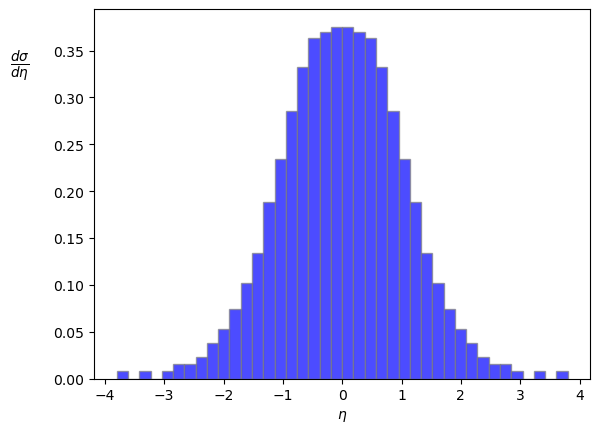

In [28]:
fig, ax = plt.subplots()
plt.hist(x = rap_P, bins = 40, density = 'True', color = 'blue', alpha = 0.7, edgecolor = 'gray', label = 'MC')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\frac{d\sigma}{d\eta}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.8)
plt.show()
# analytical function is non-trivial

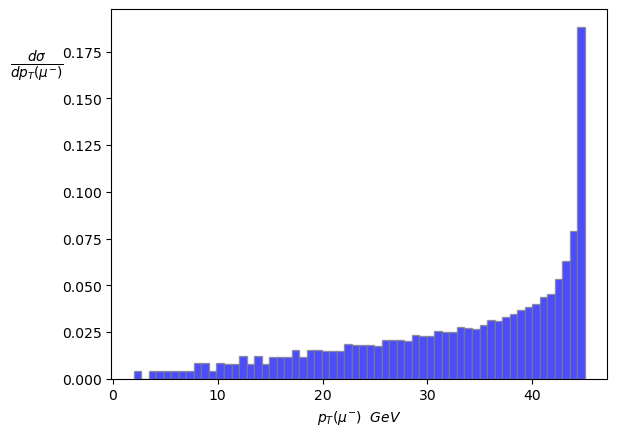

In [25]:
fig, ax = plt.subplots()
plt.hist(x = ptrans_P, bins = 60, density = 'True', color = 'blue', edgecolor = 'gray', alpha = 0.7, label = 'MC')
plt.xlabel(r'$p_T(\mu^{-})$  $GeV$')
plt.ylabel(r'$\frac{d\sigma}{dp_T(\mu^{-})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.8)
plt.show()
# analytical function non trivial